            Open  High   Low  Close    Volume
Date                                         
2014-01-02  2.62  2.62  2.59   2.61  41632500
2014-01-03  2.60  2.61  2.56   2.56  45517700
2014-01-06  2.57  2.57  2.50   2.53  68674700
2014-01-07  2.51  2.52  2.49   2.52  53293800
2014-01-08  2.51  2.54  2.49   2.51  69087900
...          ...   ...   ...    ...       ...
2014-03-25  2.53  2.54  2.52   2.54  22556600
2014-03-26  2.53  2.55  2.53   2.54  25953700
2014-03-27  2.55  2.59  2.54   2.56  52897800
2014-03-28  2.57  2.61  2.56   2.58  93338700
2014-03-31  2.58  2.59  2.56   2.59  42516900

[62 rows x 5 columns]


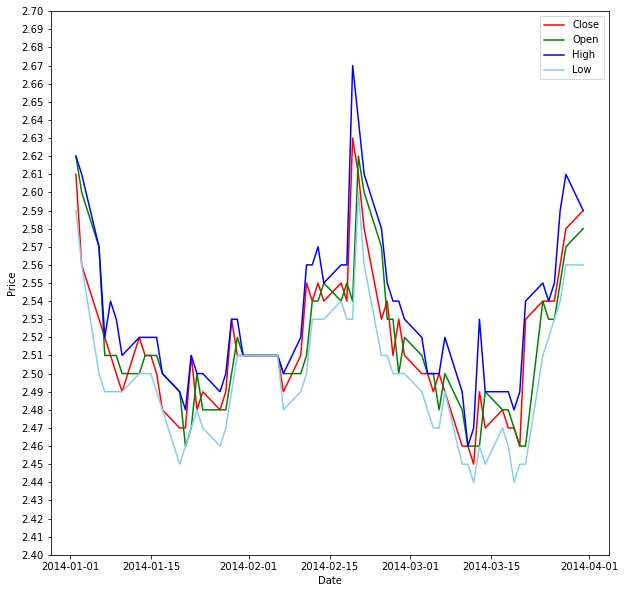

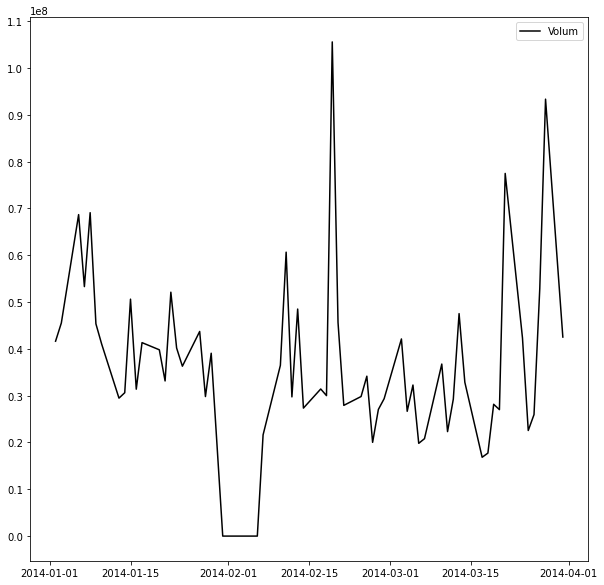

In [84]:
# load data
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import numpy as np
warnings.filterwarnings("ignore")
ChinaBank = pd.read_csv('ChinaBank.csv', index_col='Date', parse_dates=[
                        'Date']).drop(labels="Unnamed: 0", axis=1)
#ChinaBank.index = pd.to_datetime(ChinaBank.index)
sub = ChinaBank['2014-01':'2014-04']
train = sub.loc['2014-01':'2014-03']
testDf = sub.loc['2014-04-01':'2014-04-30']
plt.figure(figsize=(10, 10))
print(sub.loc['2014-01':'2014-03'])
plt.plot(train["Close"], color='red', label="Close")
plt.plot(train["Open"], color='green', label="Open")
plt.plot(train["High"], color='blue', label="High")
plt.plot(train["Low"], color='skyblue', label="Low")
plt.legend()
plt.xlabel('Date')
plt.ylabel('Price')
plt.yticks(np.arange(2.4, 2.7, 0.01))
plt.show()
plt.figure(figsize=(10, 10))
plt.plot(train["Volume"], color='black', label="Volum")
plt.legend()
plt.yticks(np.arange(0, train["Volume"].max()+1e7, 1e7))
plt.show()


0.999999999999992


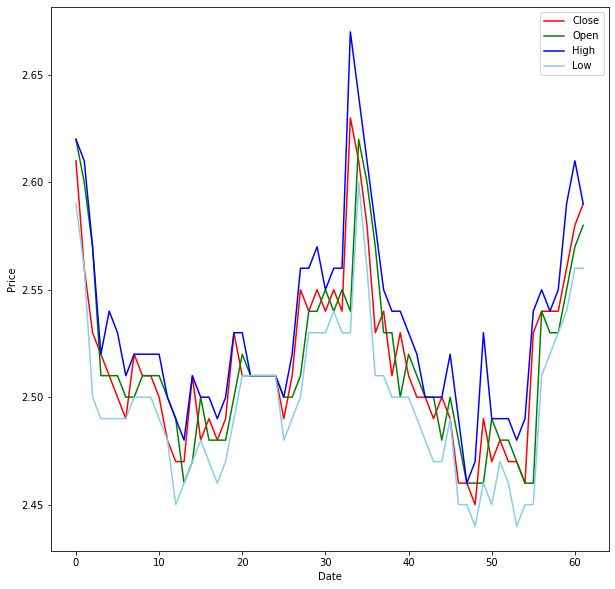

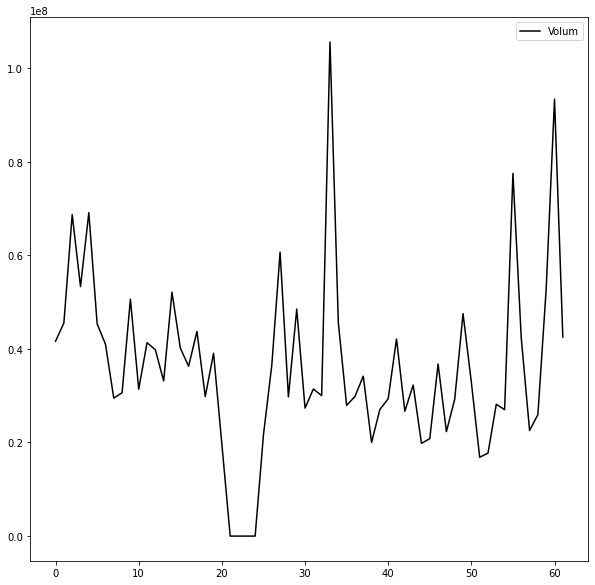

(62, 5)


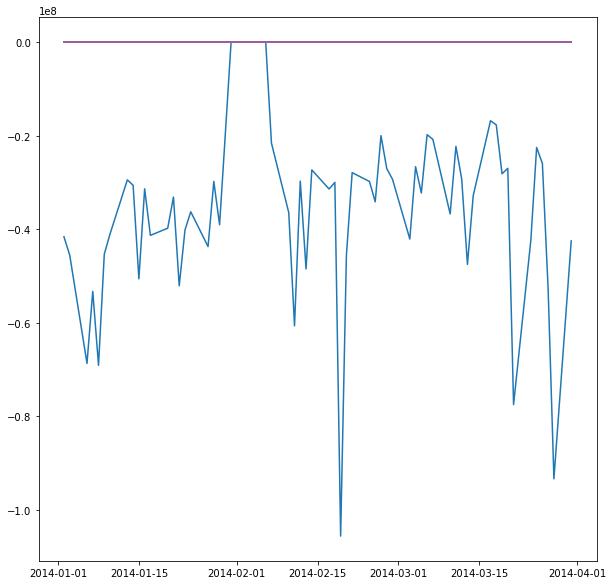

In [85]:
from sklearn.metrics import r2_score
dimension = 5
nptrain = train.to_numpy()
# print(nptrain)
u, s, vt = np.linalg.svd(nptrain)
# print(u)
# print(s)
# print(vt)
svdtrain = np.dot(vt[:dimension, :], np.mat(nptrain).T).T
predict_sunspots02 = np.dot(svdtrain, vt[:dimension, :])
print(r2_score(nptrain, predict_sunspots02))
# print(predict_sunspots02)
plt.figure(figsize=(10, 10))
plt.plot(predict_sunspots02[..., 3], color='red', label="Close")
plt.plot(predict_sunspots02[..., 0], color='green', label="Open")
plt.plot(predict_sunspots02[..., 1], color='blue', label="High")
plt.plot(predict_sunspots02[..., 2], color='skyblue', label="Low")
# plt.plot(train["Volume"],color='blacl')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()
plt.figure(figsize=(10, 10))
plt.plot(predict_sunspots02[..., 4], color='black', label="Volum")
plt.legend()
plt.show()
# print(svdtrain)
dataFrame = pd.DataFrame(svdtrain).set_index(train.index)
print(dataFrame.shape)
plt.figure(figsize=(10, 10))
plt.plot(dataFrame)
plt.show()


In [99]:
# step2：Granger’s Causality Test ， 检验不同序列之间存在互相影响
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.stats.stattools import durbin_watson

maxlag = 12
test = 'ssr_chi2test'
variables = ChinaBank.columns


def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):
    df = pd.DataFrame(np.zeros((len(variables), len(variables))),
                      columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(
                data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1], 4)
                        for i in range(maxlag)]
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df


grangers_causation_matrix(ChinaBank, variables=sub.columns)


,Open_x,High_x,Low_x,Close_x,Volume_x
Open_y,1.0000,0.0000,0.000,0.0,0.0000
High_y,0.0000,1.0000,0.000,0.0,0.0000
Low_y,0.0005,0.0000,1.000,0.0,0.0013
Close_y,0.0000,0.0007,0.001,1.0,0.0010
Volume_y,0.0000,0.0000,0.000,0.0,1.0000


In [87]:
# step3：ADF测试，检验单个变量是否平稳
def adfuller_test(series, signif=0.05, name='', verbose=False):
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic': round(r[0], 4), 'pvalue': round(
        r[1], 4), 'n_lags': round(r[2], 4), 'n_obs': r[3]}
    p_value = output['pvalue']
    def adjust(val, length=6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key, val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(
            f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")


for name, column in sub.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "Open" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.804
 No. Lags Chosen       = 0
 Critical value 1%     = -3.512
 Critical value 5%     = -2.897
 Critical value 10%    = -2.586
 => P-Value = 0.3785. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "High" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.7717
 No. Lags Chosen       = 0
 Critical value 1%     = -3.512
 Critical value 5%     = -2.897
 Critical value 10%    = -2.586
 => P-Value = 0.3946. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Low" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root

In [100]:
# step4: 协整检验，检验多变量平稳性
def cointegration_test(df, alpha=0.05):
    out = coint_johansen(df, -1, 5)
    d = {'0.90': 0, '0.95': 1, '0.99': 2}
    """Trace statistic"""
    traces = out.lr1
    """Critical values (90%, 95%, 99%) of trace statistic"""
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length=6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace, 2), 9),
              ">", adjust(cvt, 8), ' =>  ', trace > cvt)


cointegration_test(ChinaBank)


Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Open   ::  170.4     > 60.0627   =>   True
High   ::  94.39     > 40.1749   =>   True
Low    ::  31.15     > 24.2761   =>   True
Close  ::  14.19     > 12.3212   =>   True
Volume ::  2.31      > 4.1296    =>   False


In [89]:
# step6：使用VAR之间，先差分处理使单个变量变得平稳
df_differenced = dataFrame.diff().dropna()
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "0" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.9144
 No. Lags Chosen       = 2
 Critical value 1%     = -3.548
 Critical value 5%     = -2.913
 Critical value 10%    = -2.594
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "1" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.9253
 No. Lags Chosen       = 2
 Critical value 1%     = -3.548
 Critical value 5%     = -2.913
 Critical value 10%    = -2.594
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "2" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Sta

In [90]:
# # 一阶差分后仍然有些变量不平稳，进行二次差分
# df_differenced = df_differenced.diff().dropna()
# for name, column in df_differenced.iteritems():
#     adfuller_test(column, name=column.name)
#     print('\n')


In [115]:
# step7：选择模型阶数并训练，根据AIC值，lag=3时达到局部最优
model = VAR(df_differenced)
ss=pd.DataFrame(columns={'AIC','BIC','FPE','HQIC'})
for i in range(15):
    result = model.fit(i+1)
    ss.loc[str(i+1)+'阶']=[[result.aic],[result.bic],[result.fpe],[result.hqic]]
    # print('Lag Order =', i)
    # print('AIC : ', result.aic, '\n')
    # print('BIC : ', result.bic, '\n')
    # print('FPE : ', result.fpe, '\n')
    # print('HQIC : ', result.hqic, '\n')
ss

,AIC,BIC,FPE,HQIC
1阶,[-1.4705504528914766],[-0.42337817178042636],[0.23057087603690676],[-1.060943806462524]
2阶,[-1.689570956335095],[0.2471164913736268],[0.18871703024881611],[-0.9335666133212417]
3阶,[-1.6031982560446814],[1.2387921033296898],[0.2165699755421256],[-0.4961856117438064]
4阶,[-1.6315302661818496],[2.1319852271975854],[0.2346192359786538],[-0.16889989852931464]
5阶,[-1.9258983632934665],[2.7758109187702757],[0.21413552325991606],[-0.10305561785185802]
6阶,[-1.9106681128533483],[3.746361772801798],[0.31174665641588645],[0.2769510414618148]
7阶,[-2.4157497910640338],[4.214197030816882],[0.3551457907793733],[0.14116069932335762]
8阶,[-3.9511406035102867],[3.6697998168328283],[0.24782089341495178],[-1.0204944721566687]
9阶,[-8.205637917283582],[0.424863145672731],[0.04569567080903751],[-4.896907501595129]
10阶,[-inf],[-inf],[inf],[-inf]


In [172]:
# 拟合模型
model_fitted = model.fit(2)
# model_fitted.summary()


In [173]:
# step8：durbin watson test，检验残差项中是否还存在相关性，这一步的目的是确保模型已经解释了数据中所有的方差和模式
out = durbin_watson(model_fitted.resid)
for col, val in zip(sub.columns, out):
    print(round(val, 2))  # 检验值越接近2，说明模型越好


1.93
1.93
1.97
1.78
2.17


In [174]:
# step9：模型已经足够使用了，下一步进行预测
lag_order = model_fitted.k_ar
forecast_input = df_differenced.values[-lag_order:]
fc = model_fitted.forecast(y=forecast_input, steps=22)
df_forecast = pd.DataFrame(fc, index=sub.index[-22:])
df_forecast


,0,1,2,3,4
Date,,,,,
2014-04-01,-5.493744e+06,-0.586949,0.007501,-0.004008,0.020886
2014-04-02,-5.349836e+06,-0.582289,-0.002183,0.006897,-0.008068
2014-04-03,1.245633e+06,0.130368,0.005620,-0.006034,-0.001073
2014-04-04,5.011759e+06,0.543815,-0.007212,0.000509,0.001436
2014-04-07,-3.930291e+06,-0.423213,0.001929,0.001569,0.001335
2014-04-08,-1.457383e+05,-0.012927,0.000301,-0.001233,-0.000747
2014-04-09,2.135157e+06,0.232018,-0.000003,-0.000632,-0.000492
2014-04-10,4.244372e+05,0.047653,-0.000720,0.000432,0.001062
2014-04-11,-6.513162e+05,-0.069330,-0.000089,-0.000170,-0.000104


In [175]:
# step10：将差分后的值还原为原数据
def invert_transformation(df_train, df_forecast):
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:
        #df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        df_fc[col] = df_train[col].iloc[-1] + df_fc[col].cumsum()
    return df_fc


df_results = invert_transformation(dataFrame, df_forecast)
df_results
# df_results.loc[:, ['rgnp_forecast', 'pgnp_forecast', 'ulc_forecast', 'gdfco_forecast',
#                    'gdf_forecast', 'gdfim_forecast', 'gdfcf_forecast', 'gdfce_forecast']]


,0,1,2,3,4
Date,,,,,
2014-04-01,-4.801064e+07,-0.046172,0.006577,-0.012216,0.010859
2014-04-02,-5.336048e+07,-0.628461,0.004394,-0.005319,0.002791
2014-04-03,-5.211485e+07,-0.498093,0.010014,-0.011353,0.001718
2014-04-04,-4.710309e+07,0.045722,0.002801,-0.010844,0.003154
2014-04-07,-5.103338e+07,-0.377491,0.004730,-0.009275,0.004489
2014-04-08,-5.117912e+07,-0.390419,0.005031,-0.010508,0.003742
2014-04-09,-4.904396e+07,-0.158400,0.005028,-0.011139,0.003250
2014-04-10,-4.861952e+07,-0.110747,0.004308,-0.010707,0.004312
2014-04-11,-4.927084e+07,-0.180078,0.004219,-0.010877,0.004209


In [178]:
df_results=np.dot(df_results,vt[:dimension,:])
df_results=pd.DataFrame(df_results,index=testDf.index,columns=testDf.columns+"_Forecast")
df_results

,Open_Forecast,High_Forecast,Low_Forecast,Close_Forecast,Volume_Forecast
Date,,,,,
2014-04-01,2.580481,2.602160,2.577386,2.579792,4.801064e+07
2014-04-02,2.580953,2.605989,2.565539,2.585215,5.336048e+07
2014-04-03,2.582630,2.596852,2.567428,2.580845,5.211485e+07
2014-04-04,2.577687,2.596842,2.568998,2.582887,4.710309e+07
2014-04-07,2.579688,2.601835,2.569141,2.583324,5.103338e+07
2014-04-08,2.581451,2.602085,2.570973,2.585291,5.117912e+07
2014-04-09,2.582154,2.600437,2.572004,2.585296,4.904396e+07
2014-04-10,2.582144,2.601951,2.573180,2.585700,4.861952e+07
2014-04-11,2.582634,2.602829,2.573685,2.586691,4.927084e+07


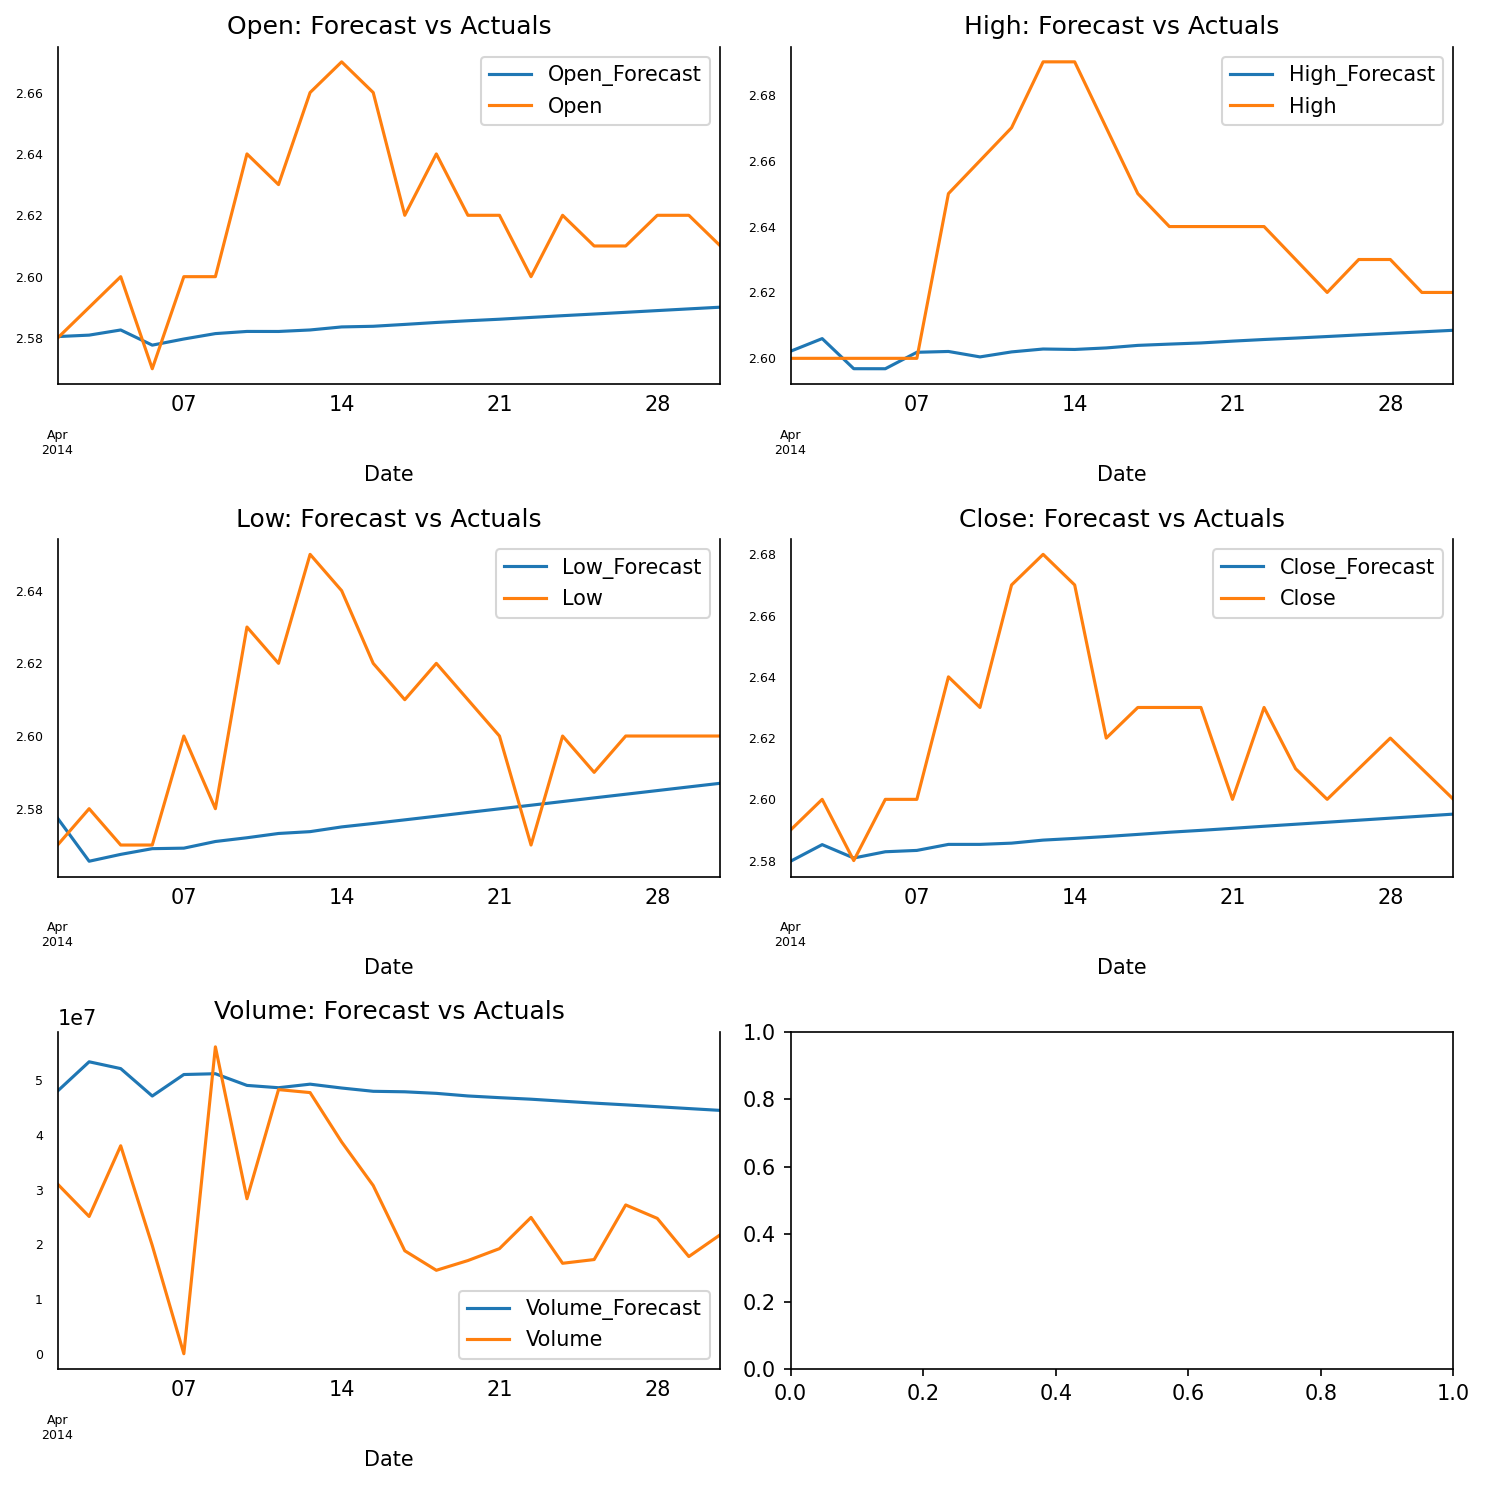

In [179]:
fig, axes = plt.subplots(nrows=3, ncols=2, dpi=150, figsize=(10, 10))
for i, (col, ax) in enumerate(zip(sub.columns, axes.flatten())):
    df_results[str(col)+"_Forecast"].plot(legend=True,
                                          ax=ax).autoscale(axis='x', tight=True)
    testDf[str(col)][-22:].plot(legend=True, ax=ax)
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()
